# Pretraining the TD Network

Goal: approximating the value function for an actor being a fixed PID, (and the partner being another fixed PID.) 
The input to the network includes predicted observations.

Steps:

Start with the skeleton of the supervised training.

- Agents shold have subjective reward, PID, and perspective.
    - agent inputs: observations/features, role
    - agent output: force
    - copy wesley's agents over.
    - modify the action space to be binary. Convert role to force.
  
- value network: 
    - input: e, e', fn, fndot
    - output: scalar
    - some ground truth: $V_e=|\int_0^e e\prime d e\prime| = 0.5e^2$ => polynomial approximation of e might work.
    - $V_f=|\int_t^T cf\prime d e\prime| = 0.5e^2$
    - try 1-3 linear layers with ReLu.
    - try: layer1=linear with large n, layer2=linear w/ glu, layer3= linear w glu, then maybe another layer 4: linear,
    
Dilemma: Should I 
1- Estimate V(s)
pro: ground truth seems straightforward. but if R includes effort, R would be stochastic (in the absense of f) which may destabilize V(s).
2- Estimate Q(s,a). The ground truth is still straight-forward.
Choice: Q(s,a)

- Make an additional copy as the target net.
- Attach the model output to value input.
- Calculate $V_{target}$ in Q-learning style. define loss. gradient update on network.


Example of agent-environment API from RLLib:
- https://github.com/ray-project/ray/blob/master/rllib/examples/custom_env.py
- https://rllib.readthedocs.io/en/latest/rllib-examples.html

In [12]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor as tarr
from numpy import asarray as narr

In [13]:
import sys, os
import importlib, time
from scipy.special import expit as sigmoid
from functools import partial
import numpy as np
from numpy import asarray as narr
import matplotlib.pyplot as plt

import env
importlib.reload(env)
from env import PhysicalDyads

In [14]:
# Agent class

agent_dir = 'agents/'

sys.path.append(agent_dir)
sys.path.append('lib/')
from agents.base import DyadSliderAgent
from nn_models import NetL1, NetRelu3L1
from lib.buffer import ReplayMemory, Transition
import role_agent
importlib.reload(role_agent)
from role_agent import RolePDAgent

In [15]:
pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0.5
agent1 = RolePDAgent(pdcont1, sigma=0.5, perspective=0)

In [16]:
print(agent1.get_force([0.2, 0.5, 1., 1.], role=0))
print(agent1.compute_utility(-0.8, 0.28))

-1.6321959135392388
-1.08


In [17]:
# Neural Network models

class NetReLu1L1(nn.Module):
# Inputs:
# r, r', x, x', f_n, f_n', f1
# Outputs:
# Q

    def __init__(self, nin, nout):
        super().__init__()
        self.fc1 = nn.Linear(nin, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, nout)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, nout)
        
    def forward(self, x):
        z1 = F.relu(self.fc1(x))#self.bn1(F.relu(self.fc1(x)))
        out = self.fc2(z1)
#         z3 = F.relu(self.fc3(z2))
#         out = self.fc4(z3)
        return out
    

class NetGlu2L1(nn.Module):
# Inputs:
# r, r', x, x', f_n, f_n', f1
# Outputs:
# Q
    def __init__(self, nin, nout):
        super().__init__()
        self.fc1 = nn.Linear(nin, 128)
        self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(64, nout)
        
    def forward(self, x):
        z1 = F.glu(self.fc1(x))
        z2 = F.glu(self.fc2(z1))
        out = self.fc3(z2)
#         z3 = F.relu(self.fc3(z2))
#         out = self.fc4(z3)
        return out

class NetL1b(nn.Module):
# Inputs:
# r, r', x, x', f_n, f_n', f1
# Outputs:
# dr, dr', dx, dx', df_n, df_n'
    def __init__(self, nin, nout):
        super().__init__()
        self.fc1 = nn.Linear(nin, nout, bias=True)
        
    def forward(self, x):
        out = self.fc1(x)
        return out

In [18]:
xtt=([1,2,3], [1,2,3],[1,2,3],[1,2,3])
ytt=(2,3,5,6)
# narr(ytt)[:,np.newaxis].shape
# narr(xtt).shape
np.concatenate( (narr(xtt), narr(ytt)[:,np.newaxis]),axis=1)

array([[1, 2, 3, 2],
       [1, 2, 3, 3],
       [1, 2, 3, 5],
       [1, 2, 3, 6]])

In [19]:
xtt = narr([[1,2,3],[7,3,6]])
for i, row in xtt:
    print('i=', i, ' row=', row)

ValueError: too many values to unpack (expected 2)

In [20]:
# Simulate updating the Q network for one episode

# load the model 


def train_qnet(env, agent1, agent2, optimizer, criterion, hyperparams, qnet, target_qnet, buffer):
    
        # required imports:
    # numpy as np; torch

    batch_size, _,_,_,_ = hyperparams
    old_observations = env.reset(renew_traj=True); #old_observations = np.asarray(observations)
    f1 = agent1.get_force(old_observations, qnet=target_qnet, eps=1)
    f2 = agent2.get_force(old_observations, role=0)
#     model_ftr = observations+[f1,f2]
#     network_ftr = 

    while True:
        t = env.get_time()
        observations, reward, done, _ = env.step([f1, f2])
#         observations_arr = np.asarray(observations)
#         outcome = observations_arr-old_observations
        utility = agent1.compute_utility(reward, f1)
        
        err = observations[0]-observations[2]
        if err> env.max_err*buffer.tag:
            buffer.push(old_observations, f1, observations, utility)

        # Train the model
        # Create a minibatch
        if len(buffer)>1:
            
            batch_size_ = min(len(buffer), batch_size)
            transitions = buffer.sample(batch_size_)
            batch = Transition(*zip(*transitions))
            # batch.state is a tuple. each entry is one sample.
            # each sample is a list of the feature vars.
            # For batch.action, batch.reward, the sample is a float.
            sa_batch = np.concatenate( (narr(batch.state), narr(batch.action)[:,np.newaxis]),axis=1)
            sa_batch = tarr(sa_batch)
#             print('len(batch.reward[0])', len(batch.reward[0]))
#             state_batch = torch.cat(tarr(batch.state))
#             action_batch = torch.cat(tarr(batch.action))
            
            reward_batch = tarr(narr(batch.reward))
            
            next_s_batch = narr(batch.next_state)
            
            q_pred = qnet(sa_batch).view(-1)
            target_qvals = reward_batch+ agent1.get_qvals(next_s_batch, target_qnet).max()
            
            
            # Run one step of SGD using the whole batch data
#             data, target = torch.from_numpy(data).float(), torch.from_numpy(target).float()
            optimizer.zero_grad() #zero all of the gradients
            loss = criterion(q_pred, target_qvals)
            loss.backward()# Backward pass: compute gradient of the loss with respect to model parameters.
            optimizer.step()# Update model parameters

        ###
        f1 = agent1.get_force(observations, qnet=target_qnet, eps=.1)
        f2 = agent2.get_force(observations, role=0)
        old_observations = observations
#         ftr_vec =  observations+[f1, f2]

        if done is True:
            break
    return qnet, buffer

In [21]:
# Benchmark

def policy_eval(env, agent1, agent2, qnet, n_episodes=100, normalizer=True):
    # Empirical Model Evaluation
    # For assessing the quality of the q network against a fixed agent.
    # Arguments:
    # n_episodes: the number of episodes used for averaging the quality of the policy
    # normalize: if True, the reward is normalized by the number of time steps.

#     all_loss = np.zeros((n_episodes, env.observation_space.shape[0]))
    reward_vals = np.zeros(n_episodes)


    for i_episode in range(n_episodes):
        cum_reward = 0.
#         ep_loss = torch.zeros(env.observation_space.shape[0])
        observations = env.reset(renew_traj=True);# old_observations = np.asarray(observations)
        f1 = agent1.get_force(observations, qnet=qnet, eps=1)
        f2 = agent2.get_force(observations, role=0)
#         ftr_vec = observations+[f1, f2]

        while True:
            t = env.get_time()
            observations, reward, done, _ = env.step([f1, f2])
            cum_reward += agent1.compute_utility(reward, f1)#reward
#             observations_arr = np.asarray(observations)
#             outcome = observations_arr-old_observations
#             ftr_tensor, outcome_tensor = torch.FloatTensor(ftr_vec), torch.from_numpy(outcome).float()
#             prediction = model(ftr_tensor)
            
#             ep_loss += abs(prediction-outcome_tensor)
            
            f1 = agent1.get_force(observations, qnet=qnet, eps=1)
            f2 = agent2.get_force(observations, role=0)
            
#             old_observations = observations_arr
#             ftr_vec =  observations+[f1, f2]

            if done is True:
                break
#         ep_loss = ep_loss.detach().numpy() /t
#         if normalizer is not None:
#             all_loss[i_episode,:] = ep_loss /normalizer
#         else:
#             all_loss[i_episode,:] = ep_loss
        if normalizer is True:
            reward_vals[i_episode] = cum_reward /t
        else:
            reward_vals[i_episode] = cum_reward
        
    return np.mean(reward_vals, axis=0)
    
    
def get_ftr_outcome_rms(env, actor1, actor2, n_episodes=1):
    n_steps_max = env._max_episode_steps
    
    ftrs = []
    outcomes = []

    for i_episode in range(n_episodes):
        ftr_i=[]; outcome_i = []
        
        observations = env.reset(renew_traj=True); old_observations = np.asarray(observations)
        f1 = actor1(observations, 0.) #initalize s_old, a_old
        f2 = actor2(observations, 0.)
        ftr_vec = observations+[f1, f2]
        ftr_i.append(ftr_vec)

        while True:
            t = env.get_time()
            observations, reward, done, _ = env.step([f1, f2])
            observations_arr = np.asarray(observations)
            outcome = observations_arr-old_observations
            outcome_i.append(outcome)
            
            f1 = actor1(observations, f1)
            f2 = actor2(observations, f2)
            old_observations = observations_arr
            ftr_vec =  observations+[f1, f2]

            if done is True:
                break
   
        ftrs.append(ndrms(np.asarray(ftr_i), axis=0))
        outcomes.append(ndrms(np.asarray(outcome_i), axis=0))
        
    ftrs_rms = np.mean(np.asarray(ftrs), axis=0)
    outcomes_rms = np.mean(np.asarray(outcomes), axis=0)
    return ftrs_rms, outcomes_rms
    
    
def benchmark(algo, hyperparams, qnet, target_qnet, env, agent1, agent2, xaxis_params):
    # Creates time series for algorithm quality across episodes
    
    target_qnet.load_state_dict(qnet.state_dict())
    target_qnet.eval()
    
    # Unzip arguments
    batch_size, _, buffer_max_size, experience_sift_tol, target_int = hyperparams
    n_episodes, n_intervals, n_eval = xaxis_params
    int_episodes=int(n_episodes/n_intervals)
#     # train(env, actor, optimizer, criterion, hyperparams, model, buffer)
#     algo = partial(train, env, actor, optimizer, criterion)
    
    buffer = ReplayMemory(buffer_max_size, tag=experience_sift_tol)
    
    x, y = np.zeros(n_intervals+1), np.zeros(n_intervals+1)#np.zeros((env.observation_space.shape[0], n_intervals+1))
    
#     _, outcomes_rms = get_ftr_outcome_rms(env, agent1, agent2, n_episodes=3)
#     outcomes_rms += 0.00001*(outcomes_rms==0)
    
#     print("outcomes_rm = ", outcomes_rms)
    x[0] = 0
    y[0] = policy_eval(env, agent1, agent2, target_qnet, n_episodes=n_eval, normalizer=True)#outcomes_rms)
#     y[:,0] = policy_eval(env, agent1, agent2, qnet, n_episodes=n_eval, normalizer=None)#outcomes_rms)
    
    # Evaluate the created policy once every int_episodes episodes
    for i in range(n_intervals):
#         if i%10==0: 
        print('interval ', i, ': loss= ', y[i])#y[:,i])
        
        for j in range(int_episodes):
            qnet, buffer = algo(hyperparams, qnet, target_qnet, buffer)
            if i*int_episodes+j % target_int == 0:
                target_qnet.load_state_dict(qnet.state_dict())
            
#             model, buffer = algo(hyperparams, model, buffer)
        x[i+1] = (i+1)*int_episodes
        y[i+1] = policy_eval(env, agent1, agent2, target_qnet, n_episodes=n_eval, normalizer=True)
#         y[:, i+1] = model_eval(env, agent1, agent2, model, n_episodes=n_eval, normalizer=outcomes_rms)

    return x,y, qnet
        

In [22]:
importlib.reload(role_agent)
from role_agent import RolePDAgent

interval  0 : loss=  -0.1863510282452796
interval  1 : loss=  -0.1708320775545053
interval  2 : loss=  -0.185313086722515
interval  3 : loss=  -0.1695959085493716
interval  4 : loss=  -0.17161347434411028
interval  5 : loss=  -0.18051519869490995
interval  6 : loss=  -0.18471482949565762
interval  7 : loss=  -0.18108619769142648
elapsed_t:  194.19857811927795


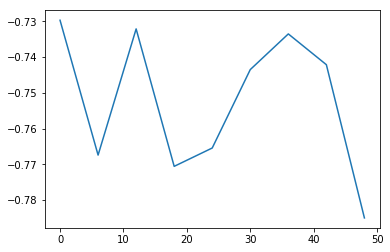

In [23]:
# Main

# Fixed objects and hyperparameters
# pdcont = [0.6, 2.]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3
agent1 = RolePDAgent(pdcont1, sigma=sigma, perspective=0, c_error=1., c_effort=0.)
agent2 = RolePDAgent(pdcont2, sigma=sigma, perspective=1)
# sigma = 1.
# agent1 = PDAgent('pd_agent', pdcont, sigma)
seed = 1234
env = PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


#Benchmark x-axis related
n_episodes = 30
n_intervals = 5 
n_eval = 5

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 10000

# Algo hyperparams
learning_rate=0.001
batch_size=32 #128
target_int = 1
# initializer = None

# NN models
env_model = NetL1(8,6)
env_model.load_state_dict(torch.load('data/env_model_sd.pth'))
env_model.eval() # set dropout and batch normalization layers to evaluation mode 

# qnet = NetL1(7, 1)
# target_qnet = NetL1(7, 1)

qnet = NetReLu1L1(7, 1)
target_qnet = NetReLu1L1(7, 1)

# qnet = NetL1b(7, 1)
# target_qnet = NetL1b(7, 1)

# qnet = NetRelu3L1(7, 1)
# target_qnet = NetRelu3L1(7, 1)

# Input:
# r, r', x, x', fn, fndot, f
# Output: q

# actor1 = agent1.get_force
# actor2 = agent2.get_force

optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
hyperparams = (batch_size, learning_rate, buffer_max_size, experience_sift_tol, target_int)
xaxis_params = (n_episodes, n_intervals, n_eval)

t0 = time.time()
# train(env, actor, optimizer, criterion, hyperparams, model, buffer)
algo = partial(train_qnet, env, agent1, agent2, optimizer, criterion)
x_f1, y_f1, qnet_f1 = benchmark(algo, hyperparams, qnet, target_qnet, env, agent1, agent2, xaxis_params)
elapsed_t = time.time() - t0
print('elapsed_t: ', elapsed_t)

plt.plot(x_f1, y_f1)

In [27]:
# importlib.reload(role_agent)
# from role_agent import RolePDAgent

agent1 = RolePDAgent(pdcont1, sigma=sigma, perspective=0, c_error=1., c_effort=0.)
# agent1 = RolePDAgent(pdcont1, sigma=sigma, perspective=0, role=0)
agent2 = RolePDAgent(pdcont2, sigma=sigma, perspective=1)

policy_eval(env, agent1, agent2, qnet_f1, n_episodes=3, normalizer=True)

-0.18302319744837156

In [30]:
def policy_ts(env, agent1, agent2, qnet):
    # Behavioral profile of the agents
    # Returns time series of events in an episode
    # Arguments:
    # normalize: if True, the reward is normalized by the number of time steps.
    eps=0; verbose=True
    
#         ep_loss = torch.zeros(env.observation_space.shape[0])
    observations = env.reset(renew_traj=True);# old_observations = np.asarray(observations)
    f1, q1vals = agent1.get_force(observations, qnet=qnet, eps=eps, verbose=verbose)
    f2 = agent2.get_force(observations, role=0)
#         ftr_vec = observations+[f1, f2]
    
    t_ts=[]
    r_ts, x_ts = [],[]
    f1_ts, f2_ts = [],[]
    u1_ts = []; cum_reward = 0.
    q10_ts, q11_ts = [],[]
    
    while True:
        t = env.get_time()
        observations, reward, done, _ = env.step([f1, f2])
        
        t_ts.append(t)
        r_ts.append(observations[0]); x_ts.append(observations[2]) # Logging
        f1_ts.append(f1) # Logging; 
        f2_ts.append(f2) # Logging
        q10_ts.append(q1vals[0])
        q11_ts.append(q1vals[1])
    
        cum_reward += reward#reward
        u1_ts.append(agent1.compute_utility(reward, f1))#reward

#         f1, q1vals = agent1.get_force(observations, qnet=qnet, eps=eps, verbose=verbose)
        f1 = agent1.get_force(observations, role=0)
        f2 = agent2.get_force(observations, role=0)

        if done is True:
            break

    cum_reward = cum_reward /t
    a1_cum_reward = np.mean(u1_ts)
        
    return t_ts, (r_ts,x_ts), (f1_ts, f2_ts), (q10_ts, q11_ts), (u1_ts, cum_reward, a1_cum_reward)

In [33]:
agent1 = RolePDAgent(pdcont1, sigma=0., perspective=0, c_error=1., c_effort=1.)
agent2 = RolePDAgent(pdcont2, sigma=0., perspective=1)
t_ts, rx_ts, forces_ts, qvals_ts, rewards = policy_ts(env, agent1, agent2, qnet_f1) 
qval_diff = narr(qvals_ts[0])-narr(qvals_ts[1])
role0 = qval_diff>0

Env Reward =  -0.15262709644888492  Agent Mean Utility =  -0.17661554820256753


Text(0.5, 0, 'Time Steps')

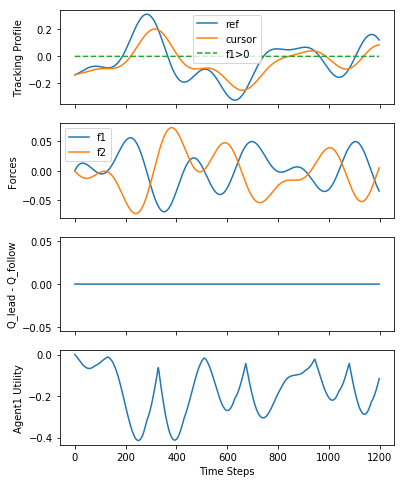

In [34]:
print('Env Reward = ', rewards[1], ' Agent Mean Utility = ', rewards[2])
fig,ax = plt.subplots(4, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role0*np.mean(abs(narr(rx_ts[0]))),ls='--', label='f1>0');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, qval_diff); ax[2].set_ylabel('Q_lead - Q_follow')
# ax[2].plot(t_ts, qvals_ts[1], label='q_follow'); 
# ax[2].set_ylabel('Action Quality'); ax[2].legend()

ax[3].plot(t_ts, rewards[0]); _=ax[3].set_ylabel('Agent1 Utility')
ax[-1].set_xlabel('Time Steps')